In [1]:
!pip install arviz
!pip install --upgrade pymc3

     |████████████████████████████████| 1.5MB 4.0MB/s 
     |████████████████████████████████| 4.1MB 21.0MB/s 
     |████████████████████████████████| 327kB 43.5MB/s 
     |████████████████████████████████| 911kB 4.5MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (6,3)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##  Техники байесовского вывода
Вы запускали модель в pymc3 и происходила какая-то магия.
Можно не сильно вдаваться в это, но немножко понимать нужно, чтобы увидеть потенциальные проблемы. Можно грубо разделить способы получения постериорного распределения на не марковские (берем честно формулу, всю и числитель и знаменатель и пытаемся как-то решить) и марковские (не считаем никаких интегралов, а весьма хитрым способом генерируем примеры, которые могли бы получиться из этой формулы), магическая аббревиатура  MCMC:Marcov Chain Monte Carlo, понять их проще, но они умеют расходится и не сходится потом. Итак.

### Не марковские:
  - иногда есть аналитическое решение (см тетрадку про сопряженное распределение) 
  - сеточные (смотрите предыдущие тетрадки)
  - квадратичные (аппроксимация постериорного распределения Гауссовым, оценка верхушки и дисперсии, решение оптимизационной задачи)
  - вариационные 
  
  Последние наше все в глубоком обучении, почти аналитические, если вдруг решите поразбираться и вас накроет печаль - не расстраивайтесь, там просто и правда все сложно. Но можно! 
  
###   MCMC:
  -  Metropolos Hastings
  -  Gibbs Sampling 
  - Hamiltonian Monte Carlo



## Сеточные методы (уже были у нас)
Проблема во взрывном росте параметров с ростом размерности. Ковид начнется и закончится, диплом напишется, а моделька все будет считаться 

In [0]:
def posterior_grid(grid_points=50, heads=6, tails=9):
    """
    A grid implementation for the coin-flipping problem
    """

    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(1/grid_points, grid_points) # uniform prior
    likelihood = stats.binom.pmf(heads, heads+tails, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, posterior

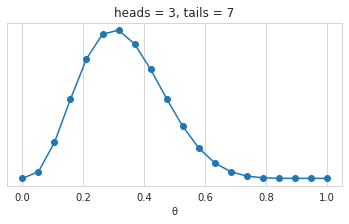

In [6]:
data = np.repeat([0, 1], (7, 3))
points = 20
h = data.sum()
t = len(data) - h
grid, posterior = posterior_grid(points, h, t)
plt.plot(grid, posterior, 'o-')
plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');

## Квадратичная аппроксимация
Предполагаем, что у нашего апостериорного распределения "хороший вид" и в районе пика его можно аппроксимировать гауссовским распределением.
Для тех же самых данных с монеткой

In [0]:
?pm.find_MAP()

In [7]:
with pm.Model() as normal_approximation:
    p = pm.Beta('p', 1., 1.)
    w = pm.Binomial('w',n=1, p=p, observed=data)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
mean_q['p'], std_q

logp = -6.9315, ||grad|| = 2: 100%|██████████| 6/6 [00:00<00:00, 447.54it/s]


(array(0.29999954), array([0.14491364]))

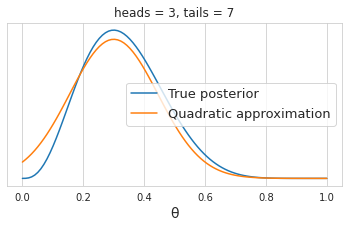

In [9]:
# analytic calculation
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , h+1, t+1),
label='True posterior')
# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q),label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)
plt.title(f'heads = {h}, tails = {t}')
plt.xlabel('θ', fontsize=14)
plt.yticks([]);

## Monte Carlo
Не про казино совсем. Сделаем вид, что мы помним кто такие интегралы. Да еще и по вероятностной мере, что совсем фантастика:) Важно только то, что такую штуку надо считать:
$$E[f]  = \int_{\theta} f(\theta)p(\theta) d\theta $$

Если вы заглянете в формулу Байеса, там полно таких. Так вот, в рамках MCMC  мы говорим, что это считать не будем, а посчитаем вот такое вместо 

$$E(f) = \lim_{\infty} \frac{1}{N}\sum_1^N f(\theta) $$

И это даже работает, но не всегда, а только асимптотически (еще одно модное слово из математики, но мое любимое  - это почти наверное)


Классический пример, и почти про казино (кто догадается при чем тут казино  - плюс балл к финальной оценке ): посчитаем число $\pi$
  - в квадрат со стороной 2R кидаем случайно $N$ точек  (его площадь будет $4R^2$)
  - внутри квадрата рисуем вписанную окружность радиуса R и посчитаем число точек которые попали туда (а площадь окружности $\pi R^2$)
  - отношение площадей круга к квадрату, умноженное на 4, в точности  должно нам дать  $\pi$.  
  - Посчитаем вместо площадей отношение числа точек, умноженное на 4.

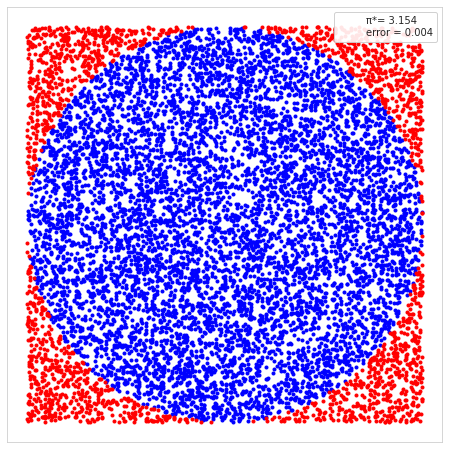

In [10]:
#поменяйте число точек, посмотрите как меняется точность
N = 10000
x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi) / pi)
outside = np.invert(inside)
plt.figure(figsize=(8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label=f'π*= {pi:4.3f}\nerror = {error:4.3f}', alpha=0)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.legend(loc=1, frameon=True, framealpha=0.9);

## Markov chain

С частью про Монте Карло разобрались. Осталось про Марковские цепи. Вообще цепь называется марковской, или процесс марковский, или свойство марковское в том случае, если следующий шаг зависит только от предыдущего, а про остальное прошлое ничего не помним. Такая вот избирательная память, очень удобно иногда. Если погуглите  - найдете много всего на эту тему, почти все в стохастической математике основано на марковских процессах.  Потому что мир так устроен, что память о прошлом ровно на один шаг? Может и да, а еще потому, что так хоть что-то можно посчитать, а иначе совсем тяжело, хотя и с одним шагом уже тяжело. Вот случайное блуждание (помните про пьяницу в канаве, который все до дома дойти не мог) - с ним все просто. 

### Алгоритм Метрополиса-Гастингса

     1) Стартуем с начального значения $x_t$
     2) Выбираем новое значение $x_{t+1}$ каким-то случайным образом, из равномерного или гауссовского распределения $q(x_{t+1}|x_t)$
     3) Оцениваем вероятность перехода в новое состояние согласно следующему критерию:
      
   $$ p_a(x_{i+1}|x_i) = min(1, \frac{p(x_{i+1})q(x_i|x_{i+1})}{p(x_i)q(x_{i+1})|x_i)}$$
   
         
     4) Переходим в новое состояние в соответствии с полученной вероятностью
     5) Повторяем процедуру, начиная с шага 2
     
Вот и весь алгоритм. Представьте, что вы приехали на озеро, у вас есть лодка и палка, очень длинная. На озеро вы приехали не просто так, а с миссией: построить карту глубины озера. А в самой глубокой точке поискать клад. Кому нужен этот праздный отдых, пусть остальные загорают на берегу. У вас есть лодка, палка и цель, а еще новое знание про Метрополиса вместе с Гастингсоном. И что со всем теперь этим делать? Для начала, перепишите алгоритм в новом контексте. Запустите итерационный процесс с воображаемым дном, выпишите несколько шагов.        

In [0]:
def metropolis(func, draws=10000):
    """A very simple Metropolis implementation"""

    trace = np.zeros(draws)
    old_x = 0.5 # func.mean()
    old_prob = func.pdf(old_x)
    delta = np.random.normal(0, 0.5, draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x
    return trace

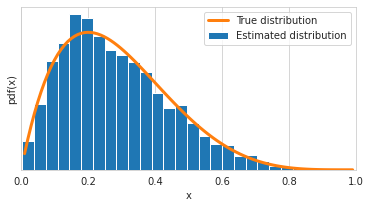

In [12]:
np.random.seed(3)
func = stats.beta(2, 5)
trace = metropolis(func=func)
x = np.linspace(0.01, .99, 100)
y = func.pdf(x)
plt.xlim(0, 1)
plt.plot(x, y, 'C1-', lw=3, label='True distribution')
plt.hist(trace, bins=25, density=True, label='Estimated distribution')
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.yticks([])
plt.legend();

В данном случае мы знали распределение заранее и оценивали вероятность прямо из него. Эффективность алгоритма сильно зависит от того, насколько близки к верной оценке отношений веротяностей на двух шагах. Обычно распределение из которого сэмплируются вероятности - многомерное гауссовское распределение, параметры которого настраиваются на предварительной стадии, а затем адаптируются в процессе. Поэтому вы могли замечать, что перед стартом требуется определенное количество времени 

### Hamiltonian Monte Carlo
У Метрополиса есть большой недостаток в процедуре выбора следующего состояния для оценки вероятности. Нужно делать очень много попыток для каждого следующего перемещения. На помощь тут приходит идея градиентного спуска (напомните мне?).  Дополнение, при котором на каждой итерации вычисляется еще и градиент и позволяет добиться на каждом шаге очень вероятного кандидата для перехода, при этом шаг становится дороже. Помните6 что в градиентном спуске у нас были параметры скорости обучения - это как мы далеко разрешаем уйти себе от точки, здесь будут те же самые проблемы, то есть нужно в ручную определять и длину шага, а еще и их количество. Эти параметры ручной настройки делают метод очень сильно зависимым от мастерства экспериментатора. В pymc3 сэмплер, в котором как раз используются эти идеи, но еще и не нужно настраивать параметры, называется NUTS (No U turn sampler) . Но если мы говорим про градиенты, то для каких распределений это подходит?  Посмотрите на симуляцию методов : https://chi-feng.github.io/mcmc-demo/

## Пример

У нас тут пока вообще не было Байеса, ну и действительно MCMC работает для широкого класса задач. А нам надо постериорное распределение получать

$$p(\theta|x)= \frac{p(x|\theta )p(\theta )}{\int_{\theta} p(x|\theta )p(\theta )d\theta}$$


Давайте рассмотрим простую модель, в которой мы знаем наши данные получены из нормального распределения с известной дисперсией, и мы хотим получить оценку среднего, после того как их увидели.

$$ p(\mu) ~\sim~ \text{Normal}(0,\sigma_0) $$
$$ p(x|\mu) ~\sim~ \text{Normal}(x;\mu,\sigma) $$

В данном случае мы знаем даже аналитический ответ, потому что имеет дело как раз с [сопряженными распределениями](https://ru.wikipedia.org/wiki/%D0%A1%D0%BE%D0%BF%D1%80%D1%8F%D0%B6%D1%91%D0%BD%D0%BD%D0%BE%D0%B5_%D0%B0%D0%BF%D1%80%D0%B8%D0%BE%D1%80%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5)

$$ p(\mu|x) ~\sim~ \text{Normal}(\frac{\mu_0/\sigma_0^2 + \sum x_i/\sigma}{n},(1/\sigma_0^2+n/\sigma^2)^{-1}$$


 


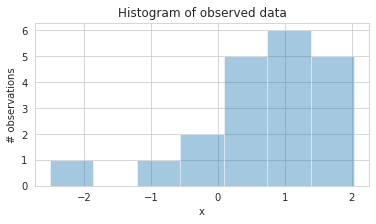

In [13]:
data = np.random.randn(20)
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

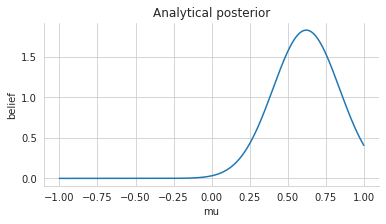

In [14]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return stats.norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

### MCMC

In [15]:
mu_current = 1.
proposal_width = 1
mu_prior_mu, mu_prior_sd = 0,1
mu_proposal = stats.norm(mu_current, proposal_width).rvs()
mu_proposal

1.7428376460384525

In [0]:
likelihood_current = stats.norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = stats.norm(mu_proposal, 1).pdf(data).prod()

# Вероятность наблюдать текущее и будущее среднее       
prior_current = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)

# Числитель в формуле байеса
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

In [17]:
p_accept = p_proposal / p_current
p_accept

8.374210482907628e-06

In [0]:
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

In [0]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        mu_proposal = stats.norm(mu_current, proposal_width).rvs()

        likelihood_current = stats.norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = stats.norm(mu_proposal, 1).pdf(data).prod()
        
        prior_current = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        p_accept = p_proposal / p_current
        
        accept = np.random.rand() < p_accept
        
        
        if accept:
            mu_current = mu_proposal
        
            posterior.append(mu_current)
        
    return np.array(posterior)



In [25]:
sampler(data)

array([0.5       , 0.62354172, 0.57344427])

###  Задание 2.
Визуализируйте результат и выясните есть ли сходимость к аналитическому виду.
А что мы еще делали с правдоподобием? (спойлер - про логарифмы, попробуйте с ними и посмотрите что получается при увеличении выборки с ними и без)

In [0]:
def sampler(data, samples=10000, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        mu_proposal = stats.norm(mu_current, proposal_width).rvs()

        likelihood_current = np.exp(np.log(stats.norm(mu_current, 1).pdf(data)).sum())
        likelihood_proposal = np.exp(np.log(stats.norm(mu_proposal, 1).pdf(data)).sum())
        
        prior_current = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = stats.norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        p_accept = p_proposal / p_current
        
        accept = np.random.rand() < p_accept
        
        
        if accept:
            mu_current = mu_proposal
        
            posterior.append(mu_current)
    
    if plot:
        ax = plt.subplot()
        ax.hist(posterior, bins=50, density=True, stacked=True)
        ax.set(xlabel='mu', ylabel='belief', title='MCMC posterior');
        sns.despine()

    return np.array(posterior)

Считается быстрее с логарифмами и суммой, но не сильно... Всё равно как-то медленно(

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


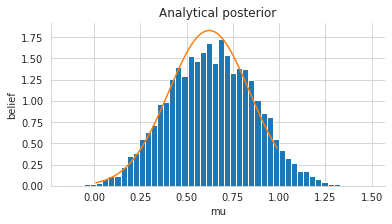

In [56]:
trace_MCMC = sampler(data, plot=True)
ax = plt.subplot()
x = np.linspace(0.01, .99, 100)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief');
sns.despine()

Аналитическое постериорное более-менее описывает постериорное, найденное через Монте Карло.

###  Задание 3
Сэмплируйте с помощью функции   metropolis, сравните результаты

In [61]:
mu_orig = data.mean()
std_orig = 1
mu_orig

0.6531183786299507

In [0]:
def posterior_metropolis(data, mu_0=data.mean(), sigma_0=data.std()):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return stats.norm(mu_post, np.sqrt(sigma_post))

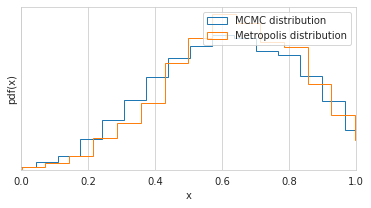

In [66]:
x = np.linspace(0.01, .99, 100)
func = posterior_metropolis(data)
trace = metropolis(func=func)
plt.xlim(0, 1)
plt.hist(trace_MCMC, bins=25, density=True, stacked=True, label='MCMC distribution', histtype='step')
plt.hist(trace, bins=25, density=True, stacked=True, label='Metropolis distribution', histtype='step')
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.yticks([])
plt.legend();

Здорово! Почти совпадают.